In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arabic-names/all_arabic_names.txt


In [2]:
words = open('../input/arabic-names/all_arabic_names.txt', 'r').read().splitlines()
len(words)

10692

In [3]:
# Tokenize characters by assigning them numerical value
# '.' is special value to indicate beginning/end of name

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
itos

{1: ' ',
 2: ',',
 3: 'ء',
 4: 'آ',
 5: 'أ',
 6: 'ؤ',
 7: 'إ',
 8: 'ئ',
 9: 'ا',
 10: 'ب',
 11: 'ة',
 12: 'ت',
 13: 'ث',
 14: 'ج',
 15: 'ح',
 16: 'خ',
 17: 'د',
 18: 'ذ',
 19: 'ر',
 20: 'ز',
 21: 'س',
 22: 'ش',
 23: 'ص',
 24: 'ض',
 25: 'ط',
 26: 'ظ',
 27: 'ع',
 28: 'غ',
 29: 'ف',
 30: 'ق',
 31: 'ك',
 32: 'ل',
 33: 'م',
 34: 'ن',
 35: 'ه',
 36: 'و',
 37: 'ى',
 38: 'ي',
 39: 'ً',
 40: 'ٌ',
 41: 'ٍ',
 42: 'َ',
 43: 'ُ',
 44: 'ِ',
 45: 'ّ',
 46: 'ْ',
 47: 'ٰ',
 0: '.'}

In [22]:
block_size = 3

# train/val/dev split = 80/10/10
def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [6]:
import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xval, Yval = build_dataset(words[n2:])

torch.Size([51343, 3]) torch.Size([51343])
torch.Size([6443, 3]) torch.Size([6443])
torch.Size([6404, 3]) torch.Size([6404])


In [7]:
C = torch.randn((48, 10))
W1 = torch.randn((30, 256))
b1 = torch.randn(256)
W2 = torch.randn((256, 48))
b2 = torch.randn(48)

params = [C, W1, b1, W2, b2]

In [8]:
sum(p.nelement() for p in params)

20752

In [9]:
for p in params:
    p.requires_grad = True

In [10]:
lri = []
losses = []
steps = []

In [11]:
for i in range(100000):
    # mini-batching
    ix = torch.randint(0, Xtr.shape[0], (64,))
    
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    if (i % 1000 == 0):
        print(loss.item())

    # backward pass
    lr = 0.1 if i < 50000 else 0.01
    
    for p in params:
        p.grad = None
    
    loss.backward()

    for p in params:
        p.data += -lr * p.grad
        
#     track stats
    losses.append(loss.log10().item()) #  just plotting loss can give graph hockey stick appearance, log squashes it
    steps.append(i)

36.85951614379883
3.675131320953369
2.9572336673736572
2.5084164142608643
2.806760549545288
2.9576950073242188
2.60847544670105
2.544825553894043
2.735724449157715
2.39209246635437
2.5830929279327393
2.745833158493042
2.5996501445770264
2.6079185009002686
2.8753044605255127
2.6845321655273438
3.024448871612549
2.435188055038452
2.534062147140503
2.5138819217681885
2.853219747543335
2.538753032684326
2.642730951309204
2.4991209506988525
2.7437784671783447
2.606325387954712
2.6000900268554688
2.6444833278656006
2.4603536128997803
2.7726497650146484
2.935007333755493
2.4120304584503174
2.464043378829956
2.0578887462615967
2.626183271408081
2.540372133255005
2.5543336868286133
2.498426675796509
2.8185689449310303
2.4568932056427
2.3554697036743164
2.362917423248291
2.772062063217163
2.1908257007598877
2.54673171043396
2.68074369430542
2.754894733428955
2.093965768814087
2.687819242477417
2.6780929565429688
2.4424760341644287
2.2697179317474365
2.485325336456299
2.6223702430725098
2.3451156

In [15]:
loss.item()

2.07842755317688

In [17]:
emb = C[Xdev]
h = torch.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.530759334564209

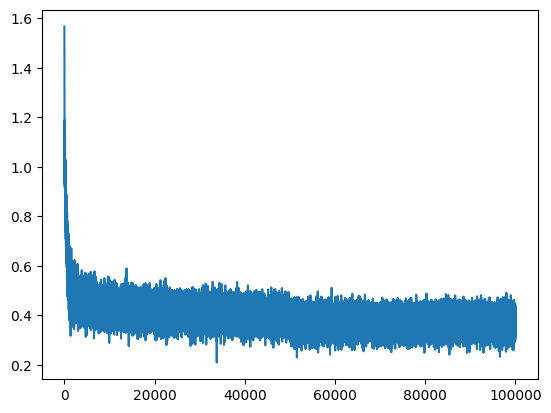

In [18]:
plt.plot(steps, losses)

In [20]:
emb = C[Xval]
h = torch.tanh(emb.view(emb.shape[0], emb.shape[1] * emb.shape[2]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.6021, grad_fn=<NllLossBackward0>)

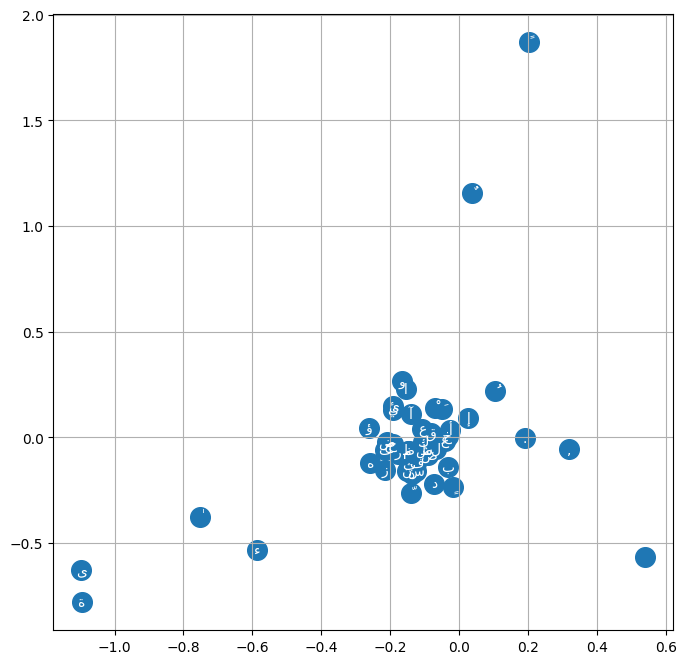

In [104]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [23]:
# sample from the model
g = torch.Generator()

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

مرزايزه.
الم.
مطيه.
تعكال.
شطاكر.
زواس.
ولا.
عبدالمل.
رفاما.
زيمت.
عبدالوه.
رمان.
عزوزدا.
ريفا.
اوويل.
مينا.
بسر.
أكر الرال.
غراسة.
راير.
